In [53]:
#!unzip data10.zip

In [54]:
styles_folder = './data10/styles10/'
masks_folder = './data10/masks10/'

In [55]:
pip install piq

In [56]:
import os
import cv2
from PIL import Image

from piq import ssim
#from piqa import SSIM 


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F

import cv2
torch.set_printoptions(precision=10)

from IPython.display import display
from PIL import Image




In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [58]:
# Display results


def display_losses(epoch, total_loss, loss_mask, loss_style, loss_12, loss_13):
    print("Epoch = ", epoch)
    print("Total Loss = {:.3f}".format(total_loss.item()))
    print("Mask Loss = {:.3f}".format(loss_mask.item()))
    print("Style Loss = {:.3f}".format(loss_style.item()))
    print("12 Loss = {:.3f}".format(loss_12.item()))
    print("13 Loss = {:.3f}".format(loss_13.item()))
    print("Same Style Loss = {:.3f}".format(loss_samestyle.item()))
    print("Same mask Loss = {:.3f}".format(loss_samemask.item()))    
    return

def display_epoch_losses(epochs, losses):
    x = list(range(epochs))
    return plt.plot(x,losses)

def display_images(image,mask,recon,flag=0):
    
    image = torch.clamp(image, 0, 1)
    mask = torch.clamp(mask, 0, 1)
    if mask.shape[1] == 1:
        mask = mask.repeat(1,3,1,1)
    recon = torch.clamp(recon, 0, 1)
    
    if flag == 1:
        print("SSIM Score = {:.3f}".format( ssim(mask, recon).item()))
    else:
        print("SSIM Score = {:.3f}".format( ssim(image, recon).item()))
    
    image = transforms.ToPILImage()(image.squeeze())
    mask = transforms.ToPILImage()(mask.squeeze())
    recon = transforms.ToPILImage()(recon.squeeze())
    
    fig =plt.figure(figsize=(5,5))
    fig.add_subplot(1,3,1);plt.imshow(image)
    fig.add_subplot(1,3,2);plt.imshow(mask)
    fig.add_subplot(1,3,3);plt.imshow(recon)

    plt.show()    

    

def display_all(gt_image, out_mask, out_image,
                gt_ss_image, ss_out_mask, ss_out_image,
                gt_sm_image, sm_out_mask, sm_out_image,
                out12_image, out13_image
               ):
    print("Base Image (Image 1)")
    display_images(gt_image, out_mask, out_image)
    
    print("\nSame Style (Image 2)")
    display_images(gt_ss_image, ss_out_mask, ss_out_image)
    
    print("\nSame Mask (Image 3)")
    display_images(gt_sm_image, sm_out_mask, sm_out_image)
    
    print("\nFirst Image style + Second Image Mask --> Expected Image 2, (Same style different mask)")
    display_images(gt_image, gt_ss_image, out12_image, flag=1)
    
    print("\nThird Image style + First Image Mask --> Expected Image 3 (Differnet style same mask)")
    display_images(gt_sm_image, gt_image, out13_image)
    
    return


In [59]:
transform = transforms.Compose(
    [transforms.ToTensor()
     ])

def get_imagetensor(location, mask=0):
    
    image = cv2.imread(location)
    if mask == 0:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = transform(image).unsqueeze(0)

    elif mask == 1:
        image_tensor = transform(image).unsqueeze(0)
        image_tensor = image_tensor.mean(axis=1).unsqueeze(0)
        
    return image_tensor

In [60]:
class mydata(Dataset):

  def __init__(self, styles_folder, masks_folder):
    self.styles = os.listdir(styles_folder) # Path to folder containing all styles
    self.styles.append(self.styles[0]) 
    self.masks = os.listdir(masks_folder) # Path to Masks
    self.masks.sort()
    self.masks.append(self.masks[0])

    self.styles_loc = styles_folder #Style names
    self.masks_loc = masks_folder

  def getlen(self):
    return len(self.styles)-1, len(self.masks)-1  

  def __getitem__(self, pos):
    si , ii = pos
    s1_loc = self.styles_loc + self.styles[si] + '/' # Style 1 images
    s2_loc = self.styles_loc + self.styles[si+1] + '/' # Style 2 images
    
    s1_images = os.listdir(s1_loc)
    s1_images.sort()
    s1_images.append(s1_images[0])
    
    s2_images = os.listdir(s2_loc)
    s2_images.sort()
    s2_images.append(s2_images[0])
    
    base_image_loc = s1_loc + s1_images[ii]
    base_mask_loc = self.masks_loc + self.masks[ii]       
    samestyle_image_loc = s1_loc + s1_images[ii+1]
    samestyle_mask_loc = self.masks_loc + self.masks[ii+1]        
    samemask_image_loc = s2_loc + s2_images[ii]
    samemask_mask_loc = self.masks_loc + self.masks[ii]

    gt_base_image = get_imagetensor(base_image_loc)
    gt_base_mask = get_imagetensor(base_mask_loc, mask=1)
    gt_ss_image = get_imagetensor(samestyle_image_loc)
    gt_ss_mask = get_imagetensor(samestyle_mask_loc, mask=1)        
    gt_sm_image = get_imagetensor(samemask_image_loc)
    gt_sm_mask = get_imagetensor(samemask_mask_loc, mask=1)

    return gt_base_image, gt_base_mask, gt_ss_image, gt_ss_mask, gt_sm_image, gt_sm_mask


In [61]:
class encoder(nn.Module):
        def __init__(self):
                super(encoder, self).__init__()
                self.conv1 = nn.Conv2d(3,64, kernel_size=3)
                self.conv2 = nn.Conv2d(64,32, kernel_size=3)
                self.conv3 = nn.Conv2d(32,16, kernel_size=3)
                
                self.conv1d1 = nn.Conv1d(16*58*58, 1024, kernel_size=1)
                self.conv1d2 = nn.Conv1d(1024,512, kernel_size=1)
                self.conv1d3 = nn.Conv1d(512,256, kernel_size=1)

                self.upconv1 = nn.ConvTranspose2d(16, 32, kernel_size=3, stride=1)
                self.upconv2 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1)
                self.upconv3 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1)
                
   
        def forward(self,x):
                #Encodings
                x = F.relu(self.conv1(x))
                x = F.relu(self.conv2(x))
                x = F.relu(self.conv3(x))
                #print("X shape", x.shape) # torch.Size([1, 16, 58, 58])
                
                #Style vector
                x_style = torch.flatten(x,1)
                x_style = x_style.unsqueeze(-1)
                x_style = F.relu(self.conv1d1(x_style))
                x_style = F.relu(self.conv1d2(x_style))
                x_style = F.relu(self.conv1d3(x_style))
                #print("Final X_Style: ", x_style.shape)

                #Image 
                x_image = F.relu(self.upconv1(x))
                x_image = F.relu(self.upconv2(x_image))
                x_image = self.upconv3(x_image)
            
#                 x_style = inverse_normalization(x_style)
#                 x_image = inverse_normalization(x_image)
                
#                 x_image = inverse_normalization(x_image)
                
                return x_style, x_image





In [62]:
class decoder(nn.Module):
        def __init__(self):
              super(decoder, self).__init__()
                  
              #Convert style for concat
              self.conv1d0 = nn.Conv1d(256,512, kernel_size=1)

              #Convert image for concat
              self.conv1 = nn.Conv2d(1,64, kernel_size=3)
              self.conv2 = nn.Conv2d(64,32, kernel_size=3)
              self.conv3 = nn.Conv2d(32,16, kernel_size=3)
              self.conv1d1 = nn.Conv1d(16*58*58, 1024, kernel_size=1)
              self.conv1d2 = nn.Conv1d(1024,512, kernel_size=1)

              #Convert image
              self.conv1d3 = nn.Conv1d(1024, 1024, kernel_size=1)
              self.conv1d4 = nn.Conv1d(1024, 1024, kernel_size=1)

              #Using Upsample + Upconv
   
              self.upsample1 = nn.Upsample(scale_factor=2,mode='bilinear')
              self.upconv1 = nn.ConvTranspose2d(16, 16, 1, stride=1)
              self.upsample2 = nn.Upsample(scale_factor=2,mode='bilinear')
              self.upconv2 = nn.ConvTranspose2d(16, 16, 1, stride=1)              
              self.upsample3 = nn.Upsample(scale_factor=2,mode='bilinear')
              self.upconv3 = nn.ConvTranspose2d(16, 3, 1, stride=1)
       
              
                

        def forward(self,x_style,x_image):
              
#               x_image /= 255.0 
              #x_style = torch.from_numpy(x_style)
              #x_image = torch.from_numpy(x_image)
                
              x1 = F.relu(self.conv1d0(x_style)) # 512 style
            
              x2 = F.relu(self.conv1(x_image))
              x2 = F.relu(self.conv2(x2))
              x2 = F.relu(self.conv3(x2))
              x2 = torch.flatten(x2, 1)
              x2 = x2.unsqueeze(-1)
              x2 = F.relu(self.conv1d1(x2))
              x2 = F.relu(self.conv1d2(x2))     # 512 image

              x = torch.cat([x1,x2], dim=1) #Linear concatenate, output = [1,1024]

              x = F.relu(self.conv1d3(x))
              x = F.relu(self.conv1d4(x))
              x = (torch.reshape(x, (16,8,8))).unsqueeze(dim=0)

              x = self.upsample1(x)
              x = F.relu(self.upconv1(x))
              x = self.upsample2(x)
              x = F.relu(self.upconv2(x))
              x = self.upsample3(x)
              x = self.upconv3(x)

#               x = inverse_normalization(x)
            
              return x


In [63]:
class MyModel(nn.Module):
    def __init__(self, enc, dec):
      super(MyModel, self).__init__()
      self.enc = enc
      self.dec = dec

    def forward(self, x):
      style, output_mask = self.enc(x)
      output_img = self.dec(style, output_mask)
      return output_img, output_mask, style


In [64]:
data = mydata(styles_folder, masks_folder)
len_styles , len_images = data.getlen()
len_styles , len_images

(5, 10)

In [69]:
enc = encoder()
dec = decoder()
model = MyModel(enc,dec).to(device)
model.to(device)

criterion = nn.MSELoss()
#criterion = ssim_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [70]:
model = model.to(device)

In [71]:
all(p.is_cuda for p in model.parameters())

True

In [72]:
num_epochs = 100

epoch_losses = []

for epoch in range(num_epochs):
    
    epoch_loss = 0
    
    for i in range(len_styles): # Number of styles 
    
        for j in range(len_images): # Number of images per style
            index = (i,j)
            gt_base_image, gt_base_mask, gt_ss_image, gt_ss_mask, gt_sm_image, gt_sm_mask = data[index]
            gt_base_image = gt_base_image.to(device)
            gt_base_mask = gt_base_mask.to(device)
            gt_ss_image = gt_ss_image.to(device)
            gt_ss_mask = gt_ss_mask.to(device)
            gt_sm_image = gt_sm_image.to(device)
            gt_sm_mask = gt_sm_mask.to(device)
            
            optimizer.zero_grad() 
    
            # Full pass
            out_image, out_mask, out_style = model(gt_base_image)
            ss_out_image, ss_out_mask, ss_out_style = model(gt_ss_image)
            sm_out_image, sm_out_mask, sm_out_style = model(gt_sm_image)
    
            # Reconstruction/Style loss
            loss_out_style = criterion(out_image.squeeze(0), gt_base_image)
            loss_ss_out_style = criterion(ss_out_image.squeeze(0), gt_ss_image)    
            loss_sm_out_style = criterion(sm_out_image.squeeze(0), gt_sm_image)
            loss_style = loss_out_style + loss_ss_out_style + loss_sm_out_style
    
            # Mask Loss
            loss_out_mask = criterion(out_mask.squeeze(0), gt_base_mask)
            loss_ss_out_mask = criterion(ss_out_mask.squeeze(0), gt_ss_mask)    
            loss_sm_out_mask = criterion(sm_out_mask.squeeze(0), gt_base_mask) # Same mask
            loss_mask = loss_out_mask + loss_ss_out_mask + loss_sm_out_mask
    
            # First Image style (Blue) + Second Image Mask (Zero) --> Expected Image 2 i.e samestyle image
            out12_image = model.dec(out_style, ss_out_mask)
            loss_12 = criterion(out12_image.squeeze(0), gt_ss_image)
    
            # Third Image style (Green) + First Image Mask (H) --> Expected Image 3 i.e samemask image
            out13_image = model.dec(sm_out_style, out_mask)
            loss_13 = criterion(out13_image.squeeze(0), gt_sm_image)
    
            # Same style vector loss
            loss_samestyle = criterion(out_style, ss_out_style)
    
            # Same mask loss
            loss_samemask = criterion(out_mask, sm_out_mask)
    
            total_loss = loss_style + loss_mask + loss_12 + loss_13 + loss_samestyle + loss_samemask
            
            epoch_loss += total_loss
            
            #display_losses(epoch, total_loss, loss_mask, loss_style, loss_12, loss_13)
            #loss.append(total_loss.item())
            
            total_loss.backward()
            optimizer.step()

    print("Epoch: ", epoch, " Loss: ", epoch_loss.item())    
    epoch_losses.append(epoch_loss.item()) 
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 3, 64, 64])) that is different to the input size (torch.Size([3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1, 64, 64])) that is different to the input size (torch.Size([1, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

Epoch:  0  Loss:  29.33159065246582
Epoch:  1  Loss:  14.616006851196289
Epoch:  2  Loss:  21.284273147583008
Epoch:  3  Loss:  13.314590454101562
Epoch:  4  Loss:  12.651219367980957
Epoch:  5  Loss:  12.67116641998291
Epoch:  6  Loss:  13.070322036743164
Epoch:  7  Loss:  12.253570556640625
Epoch:  8  Loss:  11.923789024353027
Epoch:  9  Loss:  11.923113822937012
Epoch:  10  Loss:  11.444656372070312
Epoch:  11  Loss:  11.304381370544434
Epoch:  12  Loss:  10.555737495422363
Epoch:  13  Loss:  10.063163757324219
Epoch:  14  Loss:  10.094975471496582
Epoch:  15  Loss:  10.075851440429688
Epoch:  16  Loss:  9.7080717086792
Epoch:  17  Loss:  9.28425121307373
Epoch:  18  Loss:  8.869690895080566
Epoch:  19  Loss:  8.732754707336426
Epoch:  20  Loss:  8.569171905517578
Epoch:  21  Loss:  8.056331634521484
Epoch:  22  Loss:  8.714385986328125
Epoch:  23  Loss:  7.361738204956055
Epoch:  24  Loss:  7.143249988555908
Epoch:  25  Loss:  7.0379743576049805
Epoch:  26  Loss:  6.576652050018310

In [73]:
epoch_loss

tensor(5.8024997711, device='cuda:0', grad_fn=<AddBackward0>)

Base Image (Image 1)
SSIM Score = 0.415


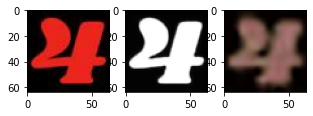


Same Style (Image 2)
SSIM Score = 0.424


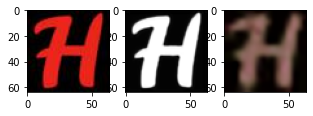


Same Mask (Image 3)
SSIM Score = 0.500


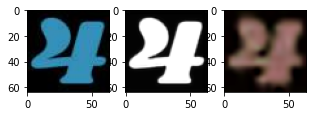


First Image style + Second Image Mask --> Expected Image 2, (Same style different mask)
SSIM Score = 0.424


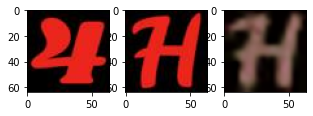


Third Image style + First Image Mask --> Expected Image 3 (Differnet style same mask)
SSIM Score = 0.501


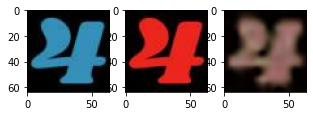

In [74]:
display_all(gt_base_image, out_mask, out_image,
                gt_ss_image, ss_out_mask, ss_out_image,
                gt_sm_image, sm_out_mask, sm_out_image,
                out12_image, out13_image
               )

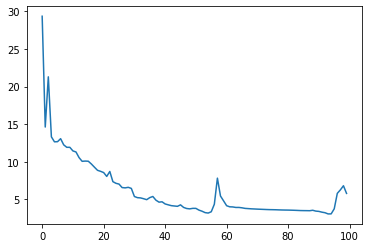

In [76]:

display_epoch_losses(num_epochs,epoch_losses)

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': total_loss
            }, 'dataloader_weights')

In [ ]:
model1 = MyModel(enc, dec)
optimizer1 = optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load('dataloader_weights')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()

In [ ]:
optimizer1.state_dict